In [74]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from env.propagators.hierarchicalPropagator import H2PlanTrackPropagator
prop = H2PlanTrackPropagator(8, device="cuda")

from agent.hierarchicalAgent import trackCW_SAC
action_bounds = [1., 1., 1.]
# sigma_bounds=  [1e2]*3
sigma_bounds=  [torch.inf]*3
h2out_ub = [ 0.06]*3
h2out_lb = [-0.06]*3
hAgent = trackCW_SAC(obs_dim=prop.obs_dim,
                    action_bounds=action_bounds,
                    sigma_upper_bounds=sigma_bounds,
                    h1a_hiddens=[512]*8, 
                    h2a_hiddens=[512]*4, 
                    h1c_hiddens=[512]*8,
                    h2out_ub=h2out_ub, 
                    h2out_lb=h2out_lb, 
                    h2a_lr=2e-3,
                    device="cuda")

import data.buffer
buffer_keys = ["states", "obss", "actions", "rewards", "next_states", "next_obss",
               "dones", "terminal_rewards"]
buffer = data.buffer.replayBuffer(buffer_keys, capacity=10000, batch_size=640)

from trainer.hierarchicalTrainer import H2Trainer, H2PlanTrackTrainer
loss_keys = ["critic_loss", "actor_loss"]
T = H2PlanTrackTrainer(prop, hAgent, buffer, loss_keys)

hAgent.load("../model/plan_track_1")

In [36]:
log = T.offPolicyTrain(20, 100, states_num=256, h1_explore_eps=0)

Output()

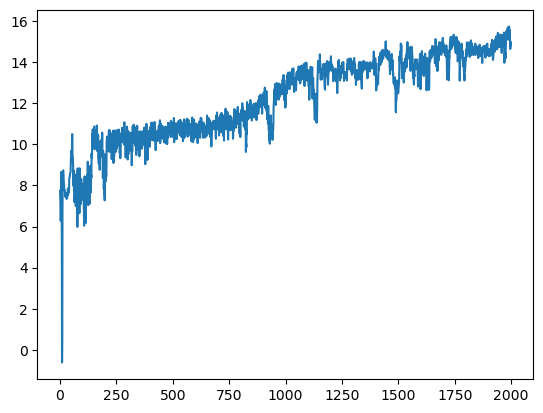

In [37]:
plt.plot(log["total_rewards"])
plt.show()

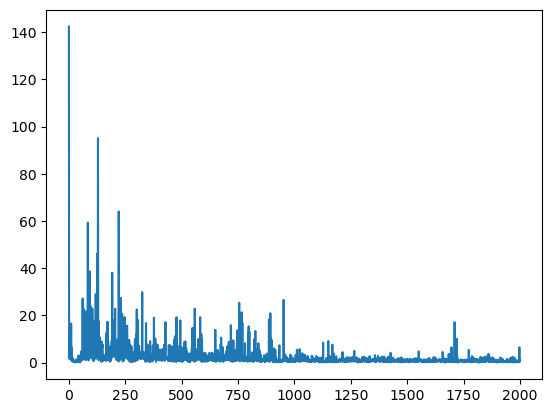

In [38]:
plt.plot(log["critic_loss"])
plt.show()

In [72]:
td, _ = T.offPolicySim()

In [ ]:
loss, logs = T.h2Pretrain(episode=100, gamma=0.99)
logs = np.array(logs)
plt.plot(loss[:])
plt.show()

In [ ]:
plt.plot(logs[:,2])
plt.show()

In [46]:
states = prop.randomInitStates(1)
targets = torch.tensor([[0.1, -0.2, 0.5]], device=prop.device)
# targets = torch.zeros((1, 3), device=prop.device)
res = T.h2Sim(states, targets, h1noise=False, prop_with_grad=False)
td = res[0]

In [31]:
states = res[1]
targets = torch.tensor([[0.1, 0.2, 0]], device=prop.device)
res = T.h2Sim(states, targets, h1noise=False, prop_with_grad=False)
td = res[0]

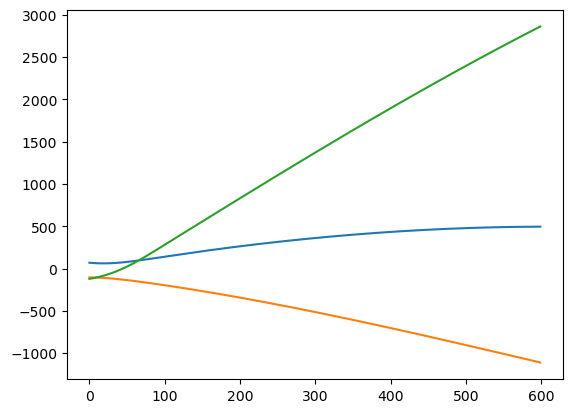

In [47]:
plt.plot(td["states"][:,0,:3].detach().cpu().numpy())
plt.show()

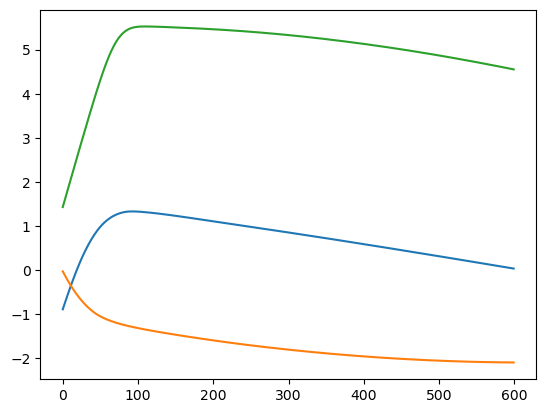

In [48]:
plt.plot(td["states"][:,0,3:6].detach().cpu().numpy())
plt.show()

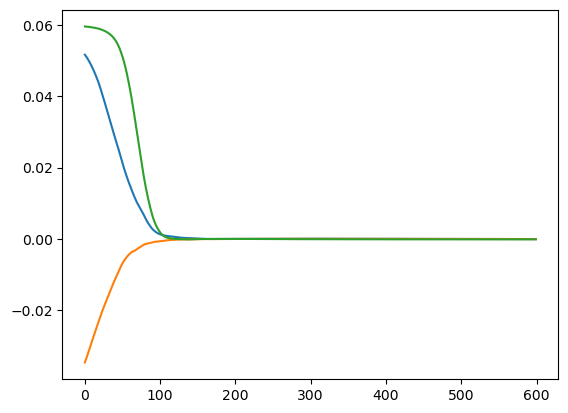

In [49]:
plt.plot(td["actions"][:,0,:3].detach().cpu().numpy())
plt.show()

In [50]:
hAgent.save("../model/plan_track_1")

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from env.propagators.hierarchicalPropagator import H2PlanTrackPropagator
from trainer.hierarchicalTrainer import H2PlanTrackTrainerV2
from trainer.myMp.mpH2 import mpH2Trainer
from data.buffer import replayBuffer

device = "cuda"
propArgs = {
    "n_debris": 8
}
hAgentArgs = {
    "action_bounds": [1., 1., 1.],
    "sigma_upper_bounds": [1e2]*3,
    "h1a_hiddens": [512]*6, 
    "h2a_hiddens": [512]*4, 
    "h1c_hiddens": [512]*6,
    "h2out_ub": [ 0.06]*3, 
    "h2out_lb": [-0.06]*3, 
    "h2a_lr": 2e-3,
}
bufferArgs = {
    "keys": None,
    "capacity": 10000,
    "batch_size": 640,
}
loss_keys = ["critic_loss", "actor_loss"]
trainerArgs = {
    "propArgs": propArgs,
    "hAgentArgs": hAgentArgs,
    "bufferArgs": None,
    "device": device,
    "loss_keys": loss_keys
}
buffer = replayBuffer(**bufferArgs)
mpt = mpH2Trainer(8, trainerCls=H2PlanTrackTrainerV2, 
                trainerArgs=trainerArgs,
                buffer=buffer)
mpt.main_agent.load("../model/plan_track_1")

In [ ]:
mpt.train(2, 100)